In [2]:
import random
from functools import partial
from pathlib import Path

from matplotlib.pyplot import figure, plot
from torch import Generator, Tensor, histogram, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.models.components.functional import Functional
from karpathy_series.makemore.models.generation import NGramNetGenerator
from karpathy_series.makemore.models.mlp import MPLNetComponents
from karpathy_series.makemore.models.sequential import CalcRecorder
from karpathy_series.makemore.training.data import DataSplit, TrainingSequencer
from karpathy_series.makemore.training.learning import Learner

random.seed(42)

%matplotlib inline
use_deterministic_algorithms(True)
rand_generator = Generator()
seed = 2147483647


def create_generator():
    return rand_generator.manual_seed(seed)

In [3]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 4
embedding_dims = 10
hidden_dims = 200

n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)
data_split = DataSplit.split(words, 80, 10, 10)
learning_sequence = ts.training_sequence(data_split.training, 32, True)
validation_set = ts.training_set(data_split.validation)

In [4]:
g = rand_generator.manual_seed(seed)
mpl_net = MPLNetComponents.init(4, char_encoder.size, embedding_dims, context_size, hidden_dims, g)
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net)
losses = []

In [5]:
print(sum(p.size() for p in mpl_net.layers), "parameters")
print("Layers:")
for k, p in enumerate(mpl_net.layers):
    print(k, p.describe())

136151 parameters
Layers:
0 Embedding [27, 10]
1 Flatten last 2 dims
2 Linear [40, 200] with bias
3 BatchNorm1d [200]
4 Functional
5 Linear [200, 200] with bias
6 BatchNorm1d [200]
7 Functional
8 Linear [200, 200] with bias
9 BatchNorm1d [200]
10 Functional
11 Linear [200, 200] with bias
12 BatchNorm1d [200]
13 Functional
14 Linear [200, 27] with bias
15 BatchNorm1d [27]


In [ ]:
learner = Learner(mpl_net, 0.01)
losses += learner(learning_sequence, epochs=50, report_epochs=10)

In [ ]:
print(mpl_net.run(*validation_set))

In [ ]:
for k in range(20):
    print(generator())

In [ ]:
plot(tensor(losses))

In [6]:
record = CalcRecorder()
loss = mpl_net.step(*next(learning_sequence()), record=record)
print(f"Step loss = {loss: .4f}")

Step loss =  3.6144


layer   4 Functional: mean  0.0028, std  0.6271, saturation  3.74%
layer   7 Functional: mean -0.0014, std  0.6326, saturation  3.34%
layer  10 Functional: mean  0.0012, std  0.6361, saturation  3.29%
layer  13 Functional: mean -0.0010, std  0.6340, saturation  3.24%


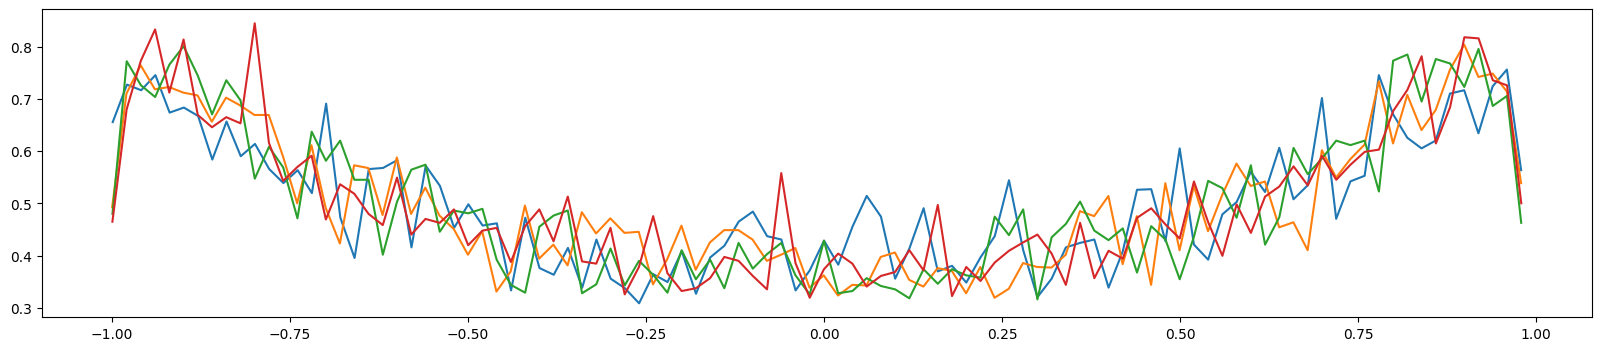

In [9]:
def saturation(out: Tensor) -> float:
    return (out.abs() > 0.97).float().mean()


figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.mean(): .4f}, std {out.std(): .4f}, saturation {saturation(out): .2%}")
        hy, hx = histogram(out, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

layer   4 Functional: mean  0.0000, std  0.0006
layer   7 Functional: mean -0.0000, std  0.0005
layer  10 Functional: mean -0.0000, std  0.0005
layer  13 Functional: mean  0.0000, std  0.0004


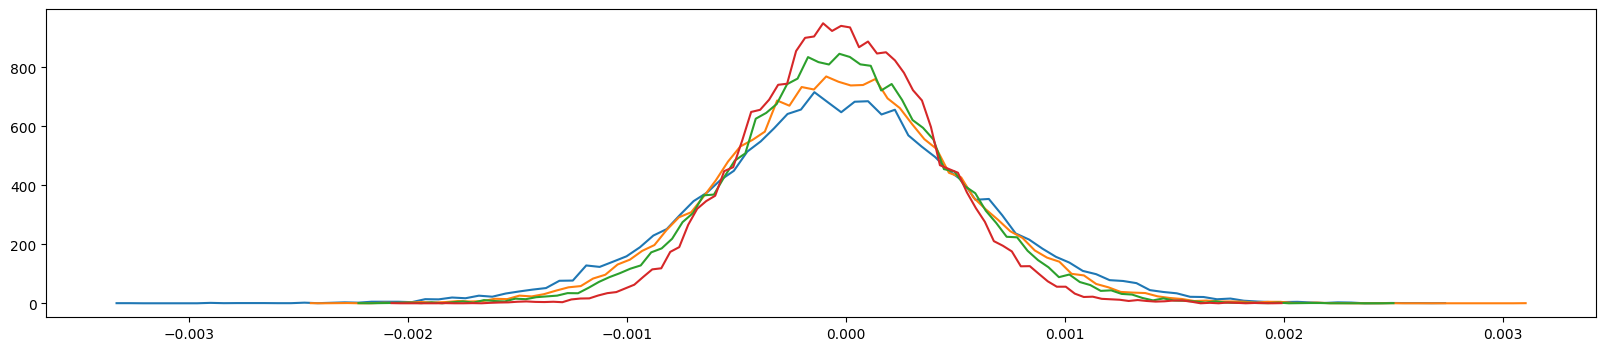

In [11]:
figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.grad.mean(): .4f}, std {out.grad.std(): .4f}")
        hy, hx = histogram(out.grad, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")